In [88]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os

In [89]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
# catalog["time"] = catalog["time"].astype("datetime64")
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [90]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [40]:
# catalog['on_land'] = globe.is_land(catalog.latitude, catalog.longitude)

In [105]:
def plot_hist(all_time_periods, earthquake_only,ax1,ax2,title1,title2):
    
#     fig.patch.set_facecolor('gray')
#     ax = plt.subplot(1,2,1)
    
    # Cumulative histogram

#     bins = np.histogram(earthquake_only, 40)[1]
    bins = np.linspace(-80,80,41)
    ax1.hist(earthquake_only, bins, density = True, cumulative=True, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax1.hist(all_time_periods, bins, density = True, cumulative=True,histtype='step',
            label='All time periods',linewidth=1.5)
    ax1.set_ylim((-0.1,1.3))
    ax1.legend()
    ax1.set_xlabel('Surface load (cm water equiv.)', fontsize = 12)
    ax1.set_ylabel("Cumulative probability", fontsize = 12)
    ax1.set_title(title1)
    
    # Non-cumulative histogram

    ax2.hist(earthquake_only, bins, density = True, cumulative=False, histtype='step',
            label='Time periods with an earthquake',linewidth=1.5)
    ax2.hist(all_time_periods, bins, density = True, cumulative=False,histtype='step',
            label='All time periods',linewidth=1.5)
    yl = ax2.get_ylim()
    ax2.set_ylim((-0.01,1.4*yl[1]))
    ax2.set_xlim((-40,60))
    ax2.legend()
    ax2.set_xlabel('Surface load (cm water equiv.)', fontsize = 12)
    ax2.set_ylabel("Probability", fontsize = 12)
    ax2.set_title(title2)

In [95]:
def calc_stats(a,b):
    '''
    Calculate stats for the distributions a and b
    a: distribution during earthquakes
    b: distribution over all time periods
    '''
    
    result = {} # this creates a dictionary
    
    result['cvm'] = stats.cramervonmises_2samp(a, b, method='auto')
    result['ks'] = stats.ks_2samp(a, b)
    result['median_all'] = np.median(b)
    result['median_eq'] = np.median(a)
    result['mean_all'] = np.mean(b)
    result['mean_eq'] = np.mean(a)
    result['mean_all_minus_mean_eq'] = np.mean(b)-np.mean(a)
    result['median_all_minus_median_eq'] = np.median(b)-np.median(a)
    
    return result

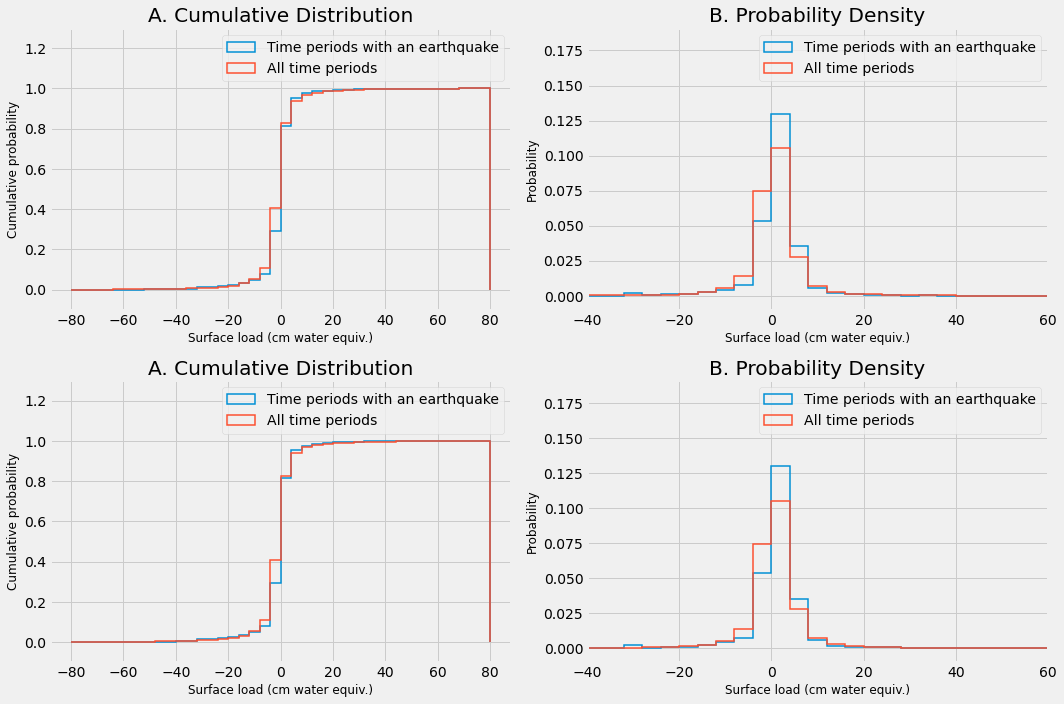

In [106]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,10))
plt.style.use('fivethirtyeight')
plot_hist(ds['lwe_thickness'].data.flatten(),catalog['dmass'],ax1,ax2,
         'A. Cumulative Distribution', 'B. Probability Density')
plot_hist(ds['lwe_thickness'].data.flatten(),catalog['dmass'],ax3,ax4,
         'A. Cumulative Distribution', 'B. Probability Density')
fig.tight_layout()

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='Surface Load (cm water equiv.)', ylabel='Relative Probability'>)

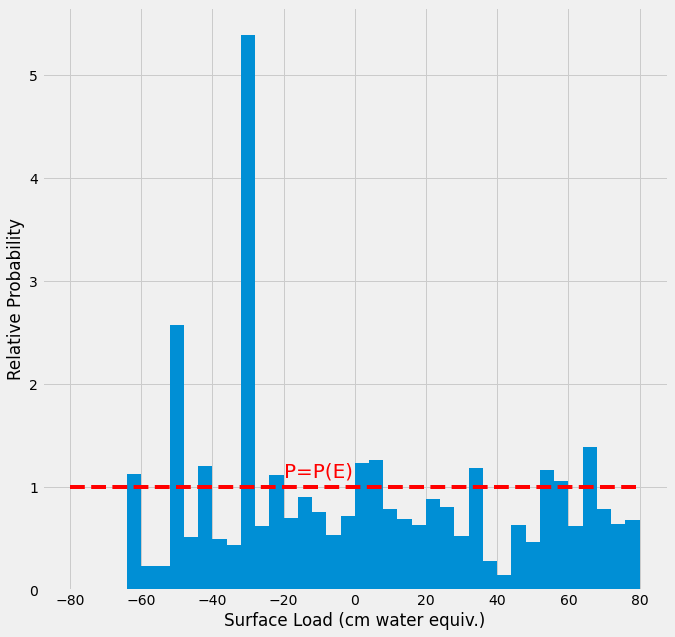

In [87]:
def plot_rel_hist(all_time_periods, earthquake_only):
    
    bins = np.linspace(-80,80,41)
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]

    fig,ax = plt.subplots(figsize=(10,10))
    plt.style.use('fivethirtyeight')
    wid = np.mean(np.diff(bins))
    plt.bar(bins[:-1]+wid/2,LgE/L,width=wid)

    plt.plot([-80,80],[1, 1],'--r')
    plt.text(-20,1.1,'P=P(E)',color='r',fontsize=20)
    plt.xlabel('Surface Load (cm water equiv.)')
    plt.ylabel('Relative Probability')
    return fig,ax

plot_rel_hist(ds['lwe_thickness'].data.flatten(),catalog['dmass'])

In [96]:
calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=60.854618746814594, pvalue=9.69405278272717e-09),
 'ks': KstestResult(statistic=0.12212035878155786, pvalue=2.4886704147936648e-123),
 'median_all': 0.6627782418257632,
 'median_eq': 1.425528633547053,
 'mean_all': -0.5782975724802435,
 'mean_eq': 1.1185184026716928,
 'mean_all_minus_mean_eq': -1.6968159751519363,
 'median_all_minus_median_eq': -0.7627503917212898}

## Correlation between reconstructed D values and seismic activity


In [ ]:
# Loading D values from pca grace

D_eq_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_eq_%d.csv'%filenumber)
    D_eq_values.append( np.loadtxt(filename, delimiter=',') )
    # asumes filenames like 'D_eq_values_1.csv', 'D_eq_values_2.csv', and so on

D_values = []
for filenumber in np.arange(1,7):
    filename = os.path.join('/data/fast1/surface-load/pca/','D_%d.csv'%filenumber)
    D_values.append( np.loadtxt(filename, delimiter=',') )

In [ ]:
stats = []

for i in range(6):
    stats.append(calc_stats(D_eq_values[i], D_values[i]))

pd.DataFrame(stats)


In [ ]:
for i in range(6):
    plot_hist(D_values[i].flatten(), D_eq_values[i])

In [ ]:
# np.median(D.flatten())
# np.median(D_eq_values.flatten())

## Correlation between D values reconstructed from detrended data and seismic activity

In [ ]:
# Loading detrended data

D_detrend_eq_values = []
for filenumber in np.arange(1,7):
    D_detrend_eq_values.append( np.loadtxt('D_detrend_eq_%d.csv'%filenumber, delimiter=',') )

D_detrend_values = []
for filenumber in np.arange(1,7):
    D_detrend_values.append( np.loadtxt('D_detrend_%d.csv'%filenumber, delimiter=',') )

In [ ]:
for i in range(6):
    plot_hist(D_detrend_values[i].flatten(), D_detrend_eq_values[i])

In [ ]:
stats_detrend = []

for i in range(6):
    stats_detrend.append(calc_stats(D_detrend_eq_values[i], D_detrend_values[i]))

In [ ]:
stats_detrend

# For next time

1. Plot **maps** of the first six PC's for the detrended and not detrended analyses
2. Based on these maps, decide where we think the line is bewteen significant PC's and noise
3. Remake plots (histograms and maps) showing ony the significant PCs

For the poster, all plots will need axis labels and a larger font and titles

## Maps 

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(catalog.longitude, catalog.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(8,6))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

# gdi = gpd.GeoDataFrame(df_ind, geometry=gpd.points_from_xy(df_ind.longitude, df_ind.latitude))
# gdi.plot(ax=ax, markersize = 5)

# plt.show()

In [ ]:
# function to plot maps of earthquake distribution

def plot_map(thr, earthquake_only):
    
    df_bigmass = catalog[np.abs(earthquake_only) > thr]
    gdf = gpd.GeoDataFrame(df_bigmass,
                           geometry=gpd.points_from_xy(df_bigmass.longitude, 
                                                   df_bigmass.latitude))

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25')
    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

In [ ]:
plot_map(25, catalog['dmass'])

### Maps for not detrended analyses

In [ ]:
for i in range(6):
    plot_map(25, D_eq_values[i])

### Maps for detrended analyses

In [ ]:
for i in range(6):
    plot_map(25, D_detrend_eq_values[i])

### Plotting all pcs on the same map

In [ ]:
def plot_same_map(eq_first_pc, eq_second_pc):

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    # first PC
    df_bigmass = catalog[np.abs(eq_first_pc) > 25]
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25 in first PC')


    # second pc
    df_bigmass = catalog[np.abs(eq_second_pc) > 25]
    gdf = gpd.GeoDataFrame(df_bigmass,
                       geometry=gpd.points_from_xy(df_bigmass.longitude, df_bigmass.latitude))
    gdf.plot(ax=ax, label='All earthquakes that occured at surface load > 25 in second PC')


    leg = ax.legend()
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    plt.show()

In [ ]:
plot_same_map(D_eq_values[0],D_eq_values[1])

### Plotting all pcs on the same map for detrended data

In [ ]:
plot_same_map(D_detrend_eq_values[0],D_detrend_eq_values[1])